# Introduction to CREsted with Peak Regression

In this introductory notebook, we will train a peak regression model on the mouse BICCN data and inspect the results to get a feel for the capabilities of the CREsted package.  

## Import Data

For this tutorial, we will use the mouse BICCN dataset which is available in the {func}`~crested.get_dataset` function.  
To train a CREsted peak regression model on your data, you need: 
1. A consensus regions BED file containing all the regions of interest accross cell types.
2. A folder containing the bigwig files per cell type. Each file should be named according to the cell type: {cell type name}.bw.
3. A genome fasta file and optionally a chromosome sizes file.

You could use a tool like SnapATAC2 to generate the consensus regions and bigwig files from your own data.

In [3]:
import crested

In [4]:
# Download the tutorial data
import os

os.environ[
    "CRESTED_DATA_DIR"
] = "../../../Crested_testing/data/tmp"  # Change this to your desired directory
bigwigs_folder, regions_file = crested.get_dataset("mouse_cortex_bigwig")

We can use the {func}`~crested.import_bigwigs` function to import bigwigs per cell type and a consensus regions BED file into an {class}`anndata.AnnData` object,
with the imported cell types as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

Optionally, provide a chromsizes file to filter out regions that are not within the chromsizes. 

In [5]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,  # optionally, use a different width than the consensus regions file (500bp) for the .X values calculation
    target="mean",  # or "max", "count", "logcount" --> what we will be predicting
)
adata

2024-08-13T15:13:51.224593+0200 WARNING Chromsizes file not provided. Will not check if regions are within chromosomes
2024-08-13T15:13:56.211715+0200 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end'

To train a model, we always need to add a *split* column to our dataset, which we can do using {func}`crested.pp.train_val_test_split`.  
This will add a column to the `AnnData.obs` with the split type for each region (train, val, or test).

In [6]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
)

# Alternatively, We can split randomly on the regions
# crested.pp.train_val_test_split(
#     adata, strategy="region", val_size=0.1, test_size=0.1, random_state=42
# )

print(adata.var["split"].value_counts())
adata.var

split
train    440993
val       56064
test      49936
Name: count, dtype: int64


,chr,start,end,split
region,,,,
chr1:3094805-3095305,chr1,3094805,3095305,train
chr1:3095470-3095970,chr1,3095470,3095970,train
chr1:3112174-3112674,chr1,3112174,3112674,train
chr1:3113534-3114034,chr1,3113534,3114034,train
chr1:3119746-3120246,chr1,3119746,3120246,train
...,...,...,...,...
chrX:169879313-169879813,chrX,169879313,169879813,train
chrX:169880181-169880681,chrX,169880181,169880681,train
chrX:169925477-169925977,chrX,169925477,169925977,train


## Preprocessing

### Region Width

For this example we're interested in training on wider regions than our consensus regions file (500bp) to also include some sequence information from the tails of our peaks.  

We change it to 2114 bp regions since that is what chrombpnet was originally trained on and that's the model architecture we'll be using.  
This is an arbitrary choice and can be changed to any width you prefer.  
Wider regions will mean that you don't only include sequence information from the center of the peaks and could effectively increase your dataset size if the tails of the peak include meaningful information, but could also introduce noise if the tails are not informative.  
Wider regions will also increase the computational cost of training the model. 

In [7]:
crested.pp.change_regions_width(
    adata, 2114
)  # change the adata width of the regions to 2114bp

2024-08-13T15:36:55.806853+0200 WARNING Chromsizes file not provided. Will not check if regions are within chromosomes


### Peak Normalization

Additionally, we can normalize our peak values based on the variability of the top values per cell type using the {func}`crested.pp.normalize_peaks` function.  

This function applies a normalization factor to each cell type, focusing on regions with the most significant peaks above a defined threshold and considering the variability within those peaks.

In [8]:
crested.pp.normalize_peaks(adata)

2024-08-13T15:14:38.285265+0200 INFO Filtering on top k Gini scores...
2024-08-13T15:14:40.374536+0200 INFO Added normalization weights to adata.obsm['weights']...


,chr,start,end,split
region,,,,
chr9:65604601-65606715,chr9,65604601,65606715,test
chr19:18669675-18671789,chr19,18669675,18671789,train
chr9:65674756-65676870,chr9,65674756,65676870,test
chr19:18686717-18688831,chr19,18686717,18688831,train
chr19:18712057-18714171,chr19,18712057,18714171,train
...,...,...,...,...
chr5:76528212-76530326,chr5,76528212,76530326,train
chr9:65434711-65436825,chr9,65434711,65436825,test
chr9:65460550-65462664,chr9,65460550,65462664,test


We can visualize the normalization factor for each cell type using the {func}`crested.pl.bar.normalization_weights` function to inspect which cell type peaks were up/down weighted.

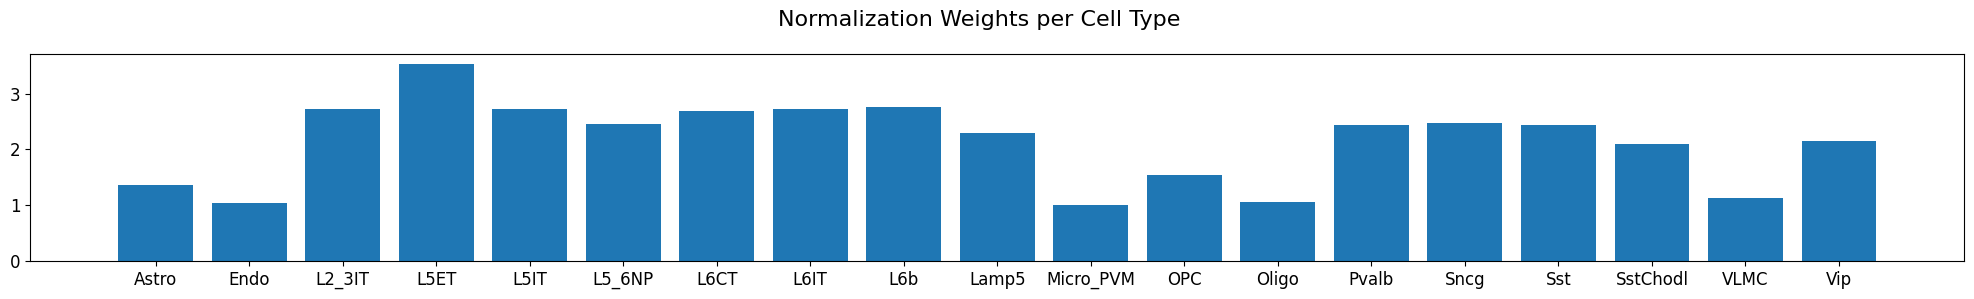

In [9]:
%matplotlib inline
crested.pl.bar.normalization_weights(adata, title="Normalization Weights per Cell Type")

### Specificity Filtering 

Optionally we can filter the regions to only include those that are specific to a cell type.  
This will reduce our training dataset size (meaning faster training times) and could improve the model's performance if the filtered out regions are not specific enough to be informative.  

A common training approach we've found to be succesful is to first train on all the regions and then filter out the non-specific regions to fine-tune the model with a lower learning rate.

Read the documentation of the {func}`crested.pp.filter_regions_on_specificity` function for more information on how the filtering is done.  

In [10]:
crested.pp.filter_regions_on_specificity(adata, gini_std_threshold=1.0)
adata

2024-08-13T15:14:50.559572+0200 INFO After specificity filtering, kept 89009 out of 546993 regions.


AnnData object with n_obs × n_vars = 19 × 89009
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split'
    obsm: 'weights'

There is no single best way to preprocess your data, so we recommend experimenting with different preprocessing steps to see what works best for your data.  
Likewise there is no single best training approach, so we recommend experimenting with different training strategies.

In [8]:
# Save the final preprocessing results
adata.write_h5ad("../../../Crested_testing/data/tmp/preprocessed_data.h5ad")

## Model Training

The entire CREsted workflow is built around the {func}`crested.tl.Crested` class.
Everything that requires a model (training, evaluation, prediction) is done through this class.  
This class has a couple of required arguments:
- `data`: the {class}`crested.tl.data.AnnDataModule` object containing all the data (anndata, genome) and dataloaders that specify how to load the data.
- `model`: the {class}`keras.Model` object containing the model architecture.
- `config`: the {class}`crested.tl.TaskConfig` object containing the optimizer, loss function, and metrics to use in training.  

Generally you wouldn't run these steps in a notebook, but rather in a script or a python file so you could run it on a cluster or in the background.

### Data

We'll start by initializing the {class}`crested.tl.data.AnnDataModule` object with our data.  
This will tell our model how to load the data and what data to load during fitting/evaluation.
The main arguments to supply are the `adata` object, the `genome` file path, and the `batch_size`.  
Other optional arguments are related to the training data loading (e.g. shuffling, whether to load the sequences into memory, ...).

The genome file you need to provide yourself as this is not included in the crested package.

In [1]:
import crested

In [2]:
# read in your preprocessed data
import anndata

adata = anndata.read_h5ad("../../../Crested_testing/data/tmp/preprocessed_data.h5ad")

In [3]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file="../../../Crested_testing/data/tmp/mm10.fa",
    batch_size=128,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional augmentation
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

2024-08-13T15:22:51.519020+0200 WARNING Chromsizes file not provided when shifting. Will not check if shifted regions are within chromosomes


### Model definition 

Next, we'll define the model architecture. This is a standard Keras model definition, so you can provide your own model definition if you like.  
Alternatively, there are a couple of ready-to-use models available in the `crested.tl.zoo` module.  
Each of them require the width of the input sequences and the number of output classes (your `Anndata.obs`) as arguments.

In [4]:
# Load chrombpnet architecture for a dataset with 2114bp regions and 19 cell types
model_architecture = crested.tl.zoo.chrombpnet(seq_len=2114, num_classes=19)

### TaskConfig

The TaskConfig object specifies the optimizer, loss function, and metrics to use in training (we call this our 'task').  
Some default configurations are available for some common tasks such as 'topic_classification' and 'peak_regression',
which you can load using the {func}`crested.tl.default_configs` function.  

In [5]:
# Load the default configuration for training a topic classication model
from crested.tl import default_configs, TaskConfig

config = default_configs("peak_regression")
print(config)

# If you want to change some small parameters to an existing config, you can do it like this
# For example, the default learning rate is 0.001, but you can change it to 0.0001
# config.optimizer.learning_rate = 0.0001

TaskConfig(optimizer=<keras.src.backend.torch.optimizers.torch_adam.Adam object at 0x1518354c4cb0>, loss=<crested.tl.losses._cosinemse.CosineMSELoss object at 0x1516ee6de750>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


Alternatively, you can create your own TaskConfig object and specify the optimizer, loss function, and metrics yourself if you want to do something completely custom.

In [6]:
# Create your own configuration
# for example if doing classification instead of regression you could something like this:
import keras

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [
    keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
    )
]
alternative_config = TaskConfig(optimizer, loss, metrics)
print(alternative_config)

TaskConfig(optimizer=<keras.src.backend.torch.optimizers.torch_adam.Adam object at 0x1516ee6dfd40>, loss=<keras.src.losses.losses.BinaryCrossentropy object at 0x151834e1e450>, metrics=[<AUC name=auc>])


### Training

Now we're ready to train our model.
We'll create a {class}`~crested.tl.Crested` object with the data, model, and config objects we just created.  
Then, we can call the {meth}`~crested.tl.Crested.fit` method to train the model.  
Read the documentation for more information on all available arguments to customize your training (e.g. augmentations, early stopping, checkpointing, ...).  

By default: 
1. The model will continue training until the validation loss stops decreasing for 10 epochs with a maximum of 100 epochs.  
2. Every best model is saved based on the validation loss.
3. The learning rate reduces by a factor of 0.25 if the validation loss stops decreasing for 5 epochs.

In [7]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="mouse_biccn",  # change to your liking
    run_name="chrombpnet_filtered_2114bp",  # change to your liking
    logger=None,  # or 'wandb', 'tensorboard'
)

In [8]:
# train the model
trainer.fit(epochs=60)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,329,875 (24.15 MB)

 Trainable params: 6,320,659 (24.11 MB)

 Non-trainable params: 9,216 (36.00 KB)

None
2024-08-13T15:23:14.799927+0200 INFO Loading sequences into memory...


100%|██████████| 71403/71403 [00:07<00:00, 9337.03it/s] 

2024-08-13T15:23:22.525200+0200 INFO Loading sequences into memory...



100%|██████████| 9645/9645 [00:00<00:00, 9717.39it/s] 


Epoch 1/60
  57/1116 ━━━━━━━━━━━━━━━━━━━━ 6:03 343ms/step - concordance_correlation_coefficient: 0.0547 - cosine_similarity: 0.5142 - loss: 2.5419 - mean_absolute_error: 0.6500 - mean_squared_error: 2.9634 - pearson_correlation: 0.0715 - pearson_correlation_log: 0.2853 - zero_penalty_metric: 776.53042024-08-13T15:24:23.706543+0200 WARNING Training interrupted by user.


## Evaluate the model

After training, we can evaluate the model on the test set using the {meth}`~crested.tl.Crested.test` method.  
If we're still in the same session, we can simply continue using the same object.  
If not, we can load the model from disk using the {func}`~crested.tl.Crested.load_model` method.
This means that we have to create a new {class}`~crested.tl.Crested` object first.  
However, this time, since the taskconfig and architecture are saved in the .keras file, we only have to provide our datamodule.

In [5]:
import anndata
import crested

adata = anndata.read_h5ad("../../../Crested_testing/data/tmp/preprocessed_data.h5ad")

datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file="../../../Crested_testing/data/tmp/mm10.fa",
)

evaluator = crested.tl.Crested(data=datamodule)

# load an existing model
evaluator.load_model(
    "../../../Crested_testing/mouse_biccn/chrombpnet_filtered_2114bp/15.keras",
    compile=True,
)

If you experimented with many different hyperparameters for your model, chances are that you will start overfitting on your validation dataset.  
It's therefore always a good idea to evaluate your model on the test set after getting good results on your validation data to see how well it generalizes to unseen data.

In [7]:
# evaluate the model on the test set
evaluator.test()

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 0.0239
2024-08-13T15:53:51.932398+0200 INFO Test loss: 0.0239


## Predict

After training, we can also use the {meth}`~crested.tl.Crested.predict` method to predict the labels for new data and add them as a layer to the `AnnData` object.  
A common use case is to compare the predicted labels to the true labels for multiple trained models to see how well they compare.  

We can initiate a new Crested object (if you have different data) or use the existing one.  
Here we continue with the existing one since we'll use the same data as we trained on.

In [8]:
# add predictions for model checkpoint to the adata
evaluator.predict(
    adata, model_name="checkpoint_15"
)  # adds the predictions to the adata.layers["checkpoint_15"]

348/348 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step
2024-08-13T15:54:40.788075+0200 INFO Adding predictions to anndata.layers[checkpoint_15].


If you don't want to predict on the entire dataset, you can also predict on a given sequence or region using the {meth}`~crested.tl.Crested.predict_sequence` or {meth}`~crested.tl.Crested.predict_regions` methods.

Many of the plotting functions in the `crested.pl` module can be used to visualize these model predictions.  

## Contribution Scores

We can calculate the contribution scores for a **sequence** of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores_sequence` method.  
You always need to ensure that the sequence or region you provide is the same length as the model input (2114bp in our case).  

In [9]:
# random sequence of length 2114bp as an example
sequence = "A" * 2114

scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_sequence(
    sequence, class_names=["Astro", "Endo"]
)  # focus on two cell types of interest

2024-08-13T15:55:10.951464+0200 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Alternatively, you can calculate contribution scores for **regions** of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores_regions` method.  
These regions don't have to be in your original dataset, as long as they exist in the genome file that you provided to the `AnnDataModule` and they are the same length as the model input.  

In [12]:
# focus on two cell types of interest
regions_of_interest = [
    "chr18:61107770-61109884"
]  # FIRE enhancer region, should only have motifs in Micro_PVM
classes_of_interest = ["Astro", "Micro_PVM"]
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    region_idx=regions_of_interest, class_names=classes_of_interest
)

2024-08-13T15:57:15.341186+0200 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Contribution scores for regions can be plotted using the {func}`crested.pl.patterns.contribution_scores` function.  
This will generate a plot per class per region.

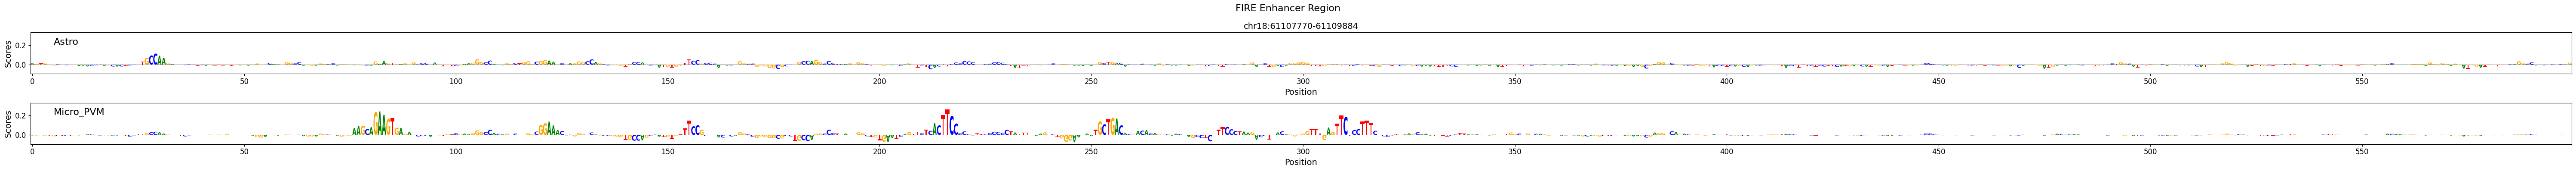

In [14]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=regions_of_interest,
    class_labels=classes_of_interest,
    zoom_n_bases=600,
    title="FIRE Enhancer Region",
)  # zoom in on the center 600bp

## Sequence evolution

We can create synthetic enhancers for a specified class using in silico evolution with the {meth}`~crested.tl.Crested.enhancer_design_in_silico_evolution` method.

In [ ]:
designed_sequences = evaluator.enhancer_design_in_silico_evolution(
    target_class="Astro", n_sequences=1, n_mutations=25
)

## TFModisco

For ease of use, we've included the TFModisco Lite functionality inside the CREsted package.  

To calculate the contribution scores in the format required for TFModisco, use the {meth}`~crested.tl.Crested.tfmodisco_calculate_and_save_contribution_scores` method.  
This will save the contribution scores in the correct format for TFModisco Lite.  

Since this will calculate contribution scores for all regions in your dataset, it's recommended to only run this on a subset of your data.  
We've included a preprocessing function {func}`crested.pp.sort_and_filter_regions_on_specificity` to keep the top k most specific regions per cell type that you can use to filter your data before running TFModisco.

In [49]:
# most informative regions per class
adata_filtered = adata.copy()
crested.pp.sort_and_filter_regions_on_specificity(adata_filtered, top_k=500)
adata_filtered

2024-08-13T16:43:03.596883+0200 INFO After sorting and filtering, kept 9500 regions.


AnnData object with n_obs × n_vars = 19 × 9500
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split', 'Class name', 'rank', 'gini_score'
    obsm: 'weights'
    layers: 'checkpoint_15'

In [50]:
# Remember to reinitialize your crested object with the new data
datamodule = crested.tl.data.AnnDataModule(
    adata_filtered,
    genome_file="../../../Crested_testing/data/tmp/mm10.fa",
)

evaluator = crested.tl.Crested(data=datamodule)

# load an existing model
evaluator.load_model(
    "../../../Crested_testing/mouse_biccn/chrombpnet_filtered_2114bp/15.keras",
    compile=True,
)

Now you can calculate the contribution scores for all the regions in your filtered anndata.  
By default, the contribution scores are calculated using the expected integrated gradients method, but you can change this to simple integrated gradients to speed up the calculation (this might result in less accurate scores).

In [ ]:
# calculate contribution scores for all regions and save them to output_dir
evaluator.tfmodisco_calculate_and_save_contribution_scores(
    output_dir="../../../Crested_testing/mouse_biccn/chrombpnet_filtered_2114bp/contribution_scores",
    method="integrated_grad",
)

When this is done, you can run TFModisco Lite on the saved contribution scores to find motifs that are important for the classification/regression task.  

You could use the tfmodisco package directly to do this, or you could use the {func}`crested.tl.tfmodisco` function which is essentially a wrapper around the tfmodisco package.

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.tfmodisco(
    contrib_dir="../../../Crested_testing/mouse_biccn/chrombpnet_filtered_2114bp/contribution_scores",
    output_dir="../../../Crested_testing/mouse_biccn/chrombpnet_filtered_2114bp/tfmodisco_results",
)

When this is done, you can plot the results using the {func}`crested.pl.patterns.modisco_results` function.

In [ ]:
%matplotlib inline
crested.pl.modisco_results(
    classes=["Astro", "Endo"],
    contribution="positive",
    contribution_dir="../../../Crested_testing/mouse_biccn/chrombpnet_filtered_2114bp/tfmodisco_results",
)

## Plotting

There is a bunch of plotting functions available in the `crested.pl` module to visualize the results of the model.
We will show some examples below, but refer to the documentation for more information.  

All the plotting functions using {func}`crested.pl.render_plot` to render the plots. You can refer to the documentation of this function to customize the plots to your liking.

### Regions of interest

In [26]:
%matplotlib inline

2024-08-13T16:16:09.870822+0200 INFO Plotting bar plots for region: chr18:60577255-60579369, models: ['checkpoint_15']


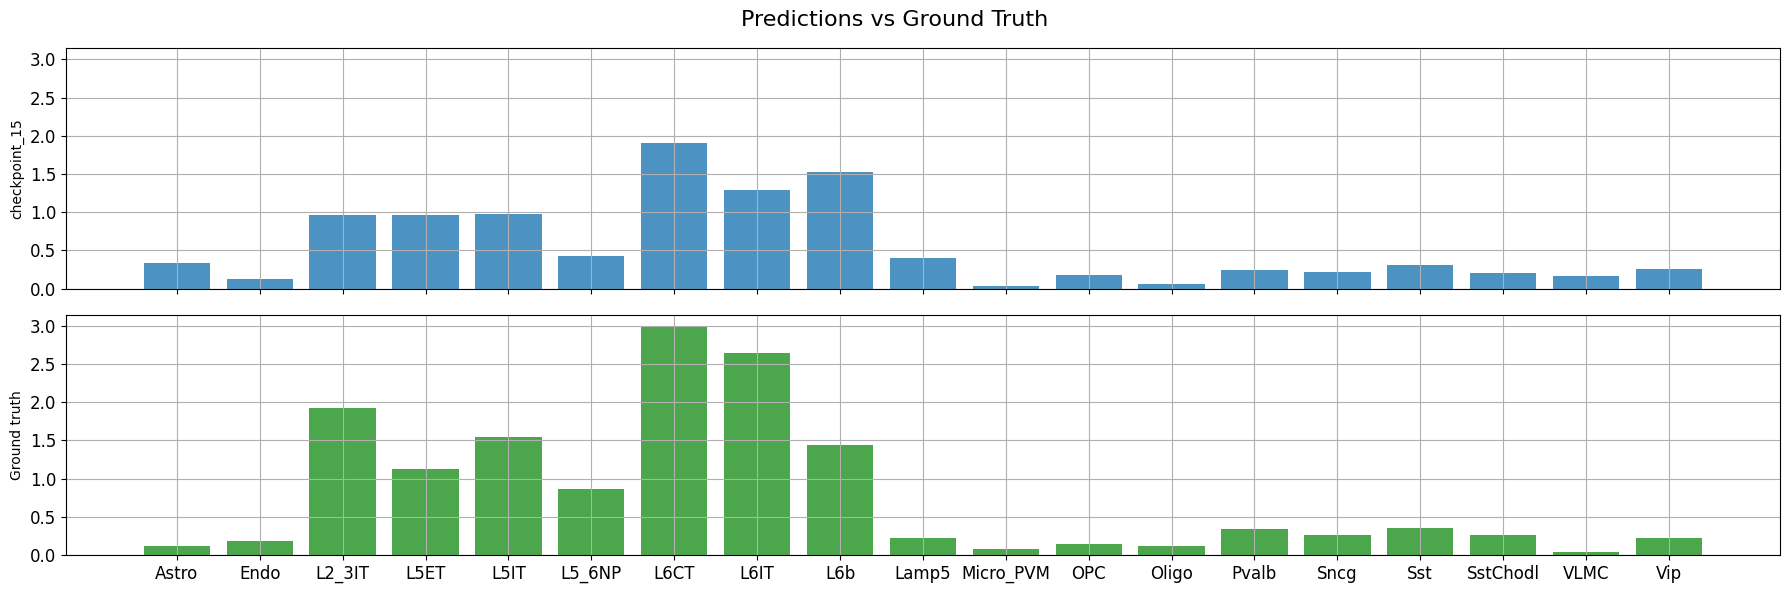

In [25]:
# plot predictions vs ground truth for a random region in the test set
crested.pl.bar.region_predictions(
    adata, "chr18:60577255-60579369", title="Predictions vs Ground Truth"
)

### Class Distributions

2024-08-13T16:20:00.057748+0200 INFO Plotting histograms for target: groundtruth, classes: ['Astro', 'Endo']


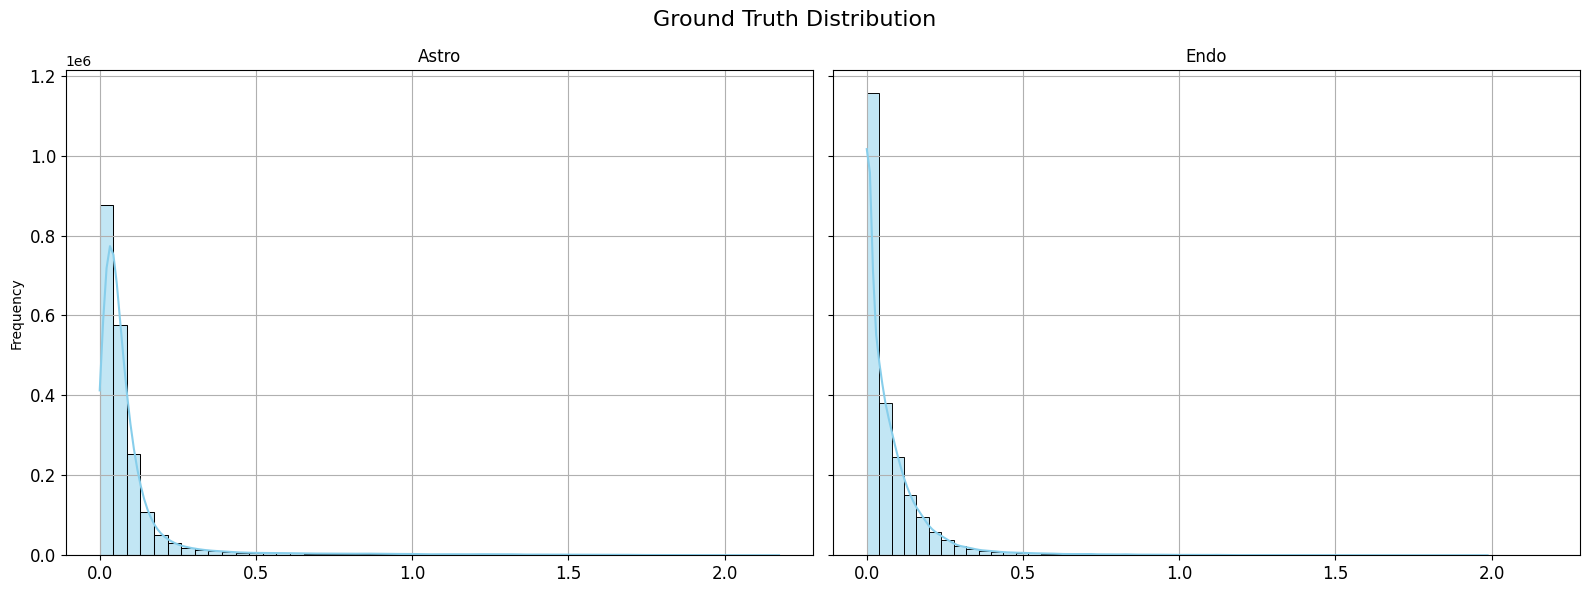

In [30]:
crested.pl.hist.distribution(
    adata,
    target="groundtruth",
    class_names=["Astro", "Endo"],
    log_transform=True,
    share_y=True,
    title="Ground Truth Distribution",
)

2024-08-13T16:20:26.880627+0200 INFO Plotting histograms for target: checkpoint_15, classes: ['Astro', 'Endo']


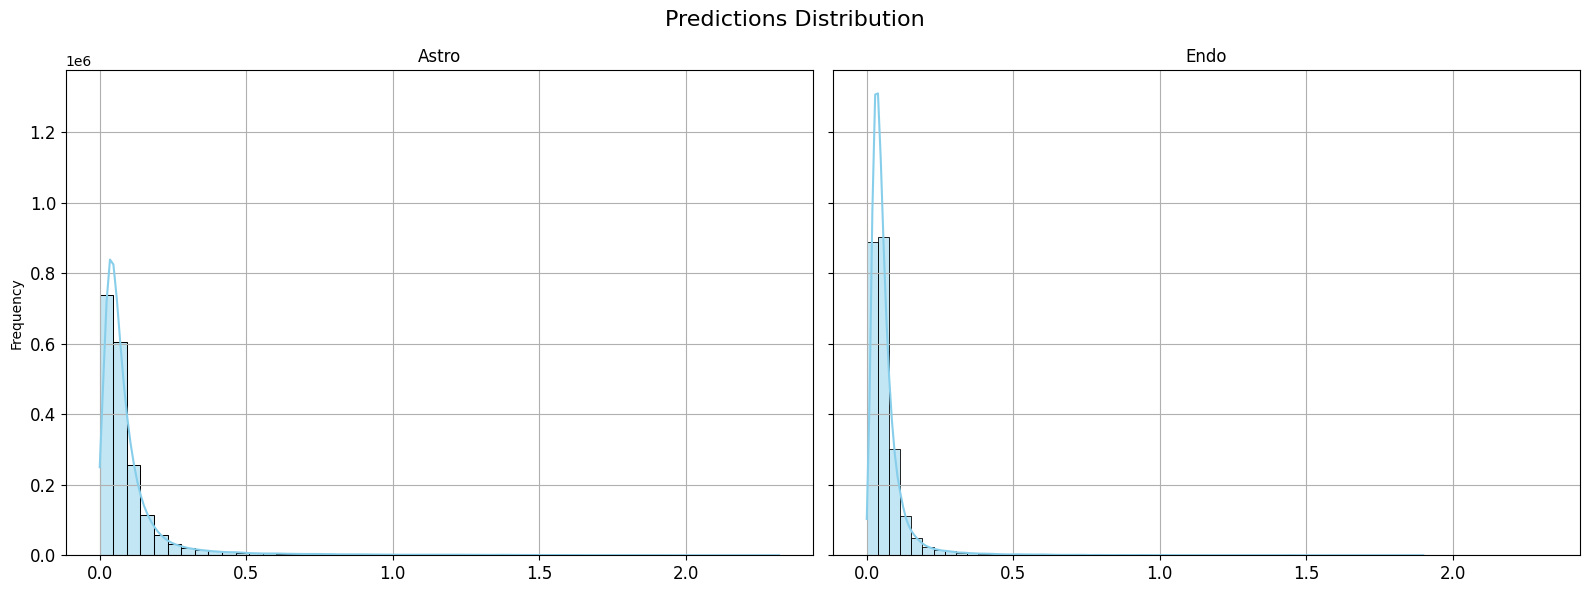

In [32]:
crested.pl.hist.distribution(
    adata,
    target="checkpoint_15",
    class_names=["Astro", "Endo"],
    log_transform=True,
    share_y=True,
    title="Predictions Distribution",
)

2024-08-13T16:26:24.294927+0200 INFO Plotting density scatter for class: Astro, models: ['checkpoint_15'], split: test


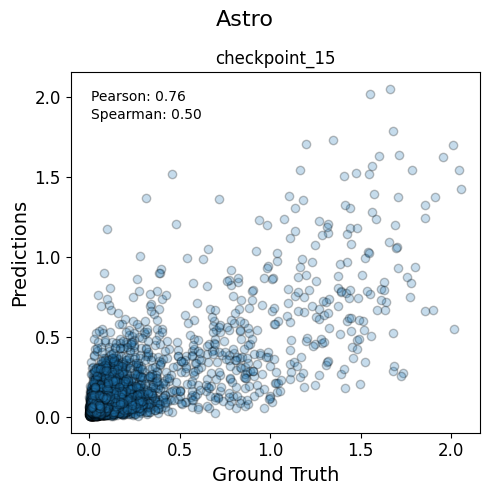

In [47]:
crested.pl.scatter.class_density(
    adata,
    class_name="Astro",
    model_names=["checkpoint_15"],
    split="test",
    log_transform=True,
    width=5,
    height=5,
)

### Correlation Heatmaps

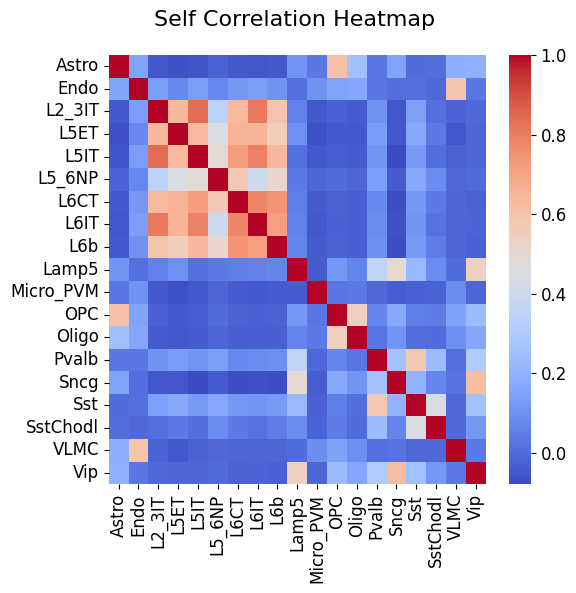

In [42]:
crested.pl.heatmap.correlations_self(
    adata, title="Self Correlation Heatmap", x_label_rotation=90, width=6, height=6
)

2024-08-13T16:24:09.270310+0200 INFO Plotting heatmap correlations for split: test, models: ['checkpoint_15']


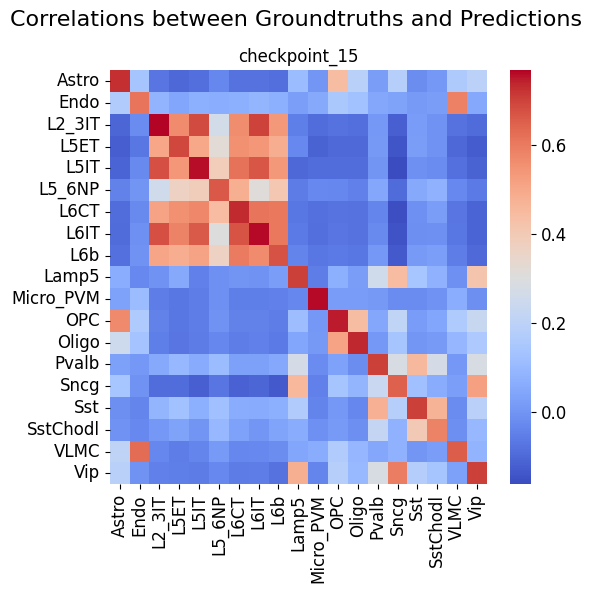

In [41]:
crested.pl.heatmap.correlations_predictions(
    adata,
    split="test",
    title="Correlations between Groundtruths and Predictions",
    x_label_rotation=90,
    width=6,
    height=6,
)